In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.insert(1, '../')

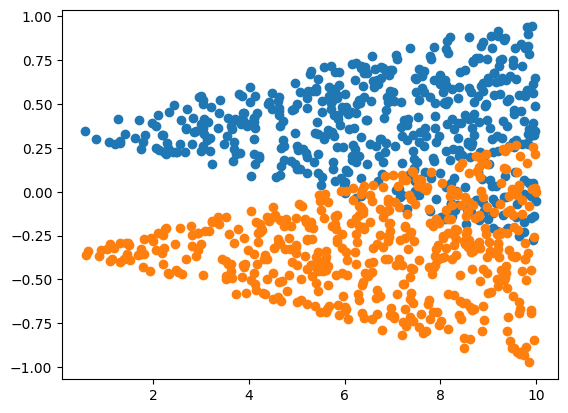

In [62]:
def point_on_triangle(pt1, pt2, pt3):
    """
    Random point on the triangle with vertices pt1, pt2 and pt3.
    """
    x, y = random.random(), random.random()
    q = abs(x - y)
    s, t, u = q, 0.5 * (x + y - q), 1 - 0.5 * (q + x + y)
    return (
        s * pt1[0] + t * pt2[0] + u * pt3[0],
        s * pt1[1] + t * pt2[1] + u * pt3[1],
    )


overlap_rate = 0.3
end = 1
traingle_length = 10
overlap = end * overlap_rate
n_samples = 1000


class_1 = np.array([point_on_triangle((0, (end - overlap)/2), (traingle_length, -overlap), (traingle_length, end)) for i in range(int(n_samples/2))])
class_2 = np.array([point_on_triangle((0, (end - overlap)/ -2), (traingle_length, overlap), (traingle_length, -end)) for i in range(int(n_samples/2))])

plt.scatter(class_1[:, 0], class_1[:, 1])
plt.scatter(class_2[:, 0], class_2[:, 1])

In [63]:
x= np.concatenate([class_1, class_2])
y = np.concatenate([np.zeros(class_1.shape[0]), np.ones(class_2.shape[0])])

In [78]:
from disentanglement.models.architectures import get_blobs_dropout_architecture, get_blobs_ensemble_architecture
from disentanglement.models.information_theoretic_models import mutual_information, expected_entropy, \
    train_it_model
from disentanglement.models.gaussian_logits_models import uncertainty, \
    train_gaussian_logits_model
from disentanglement.settings import BATCH_SIZE, NUM_SAMPLES, TEST_MODE
from tqdm import tqdm
from sklearn.metrics import accuracy_score


epochs = 300
architecture_func = get_blobs_ensemble_architecture
n_classes = 2


disentangle_model = train_gaussian_logits_model(architecture_func, x, y, n_classes,
                                                epochs=epochs)
entropy_model = train_it_model(architecture_func, x, y, n_classes, epochs=epochs)


 12%|███████████████████████████████▌                                                                                                                                                                                                                                                  | 60/520 [53:00<16:30,  2.15s/it]

In [104]:

res = 0.3
min_x, max_x = [-2, -1.5] , [15, 1.5 + res]

xx, yy = np.meshgrid(np.arange(min_x[0], max_x[0], res), np.arange(min_x[1], max_x[1], res))
domain = np.c_[xx.ravel(), yy.ravel()]


In [105]:
pred_mean, pred_ale_std, pred_epi_std = disentangle_model.predict(domain, batch_size=BATCH_SIZE)
entropy_preds = entropy_model.predict_samples(domain, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)

gauss_logits_aleatoric = uncertainty(pred_ale_std).reshape(xx.shape)
gauss_logits_epistemic = uncertainty(pred_epi_std).reshape(xx.shape)

it_aleatoric = expected_entropy(entropy_preds).reshape(xx.shape)
it_epistemic = mutual_information(entropy_preds).reshape(xx.shape)

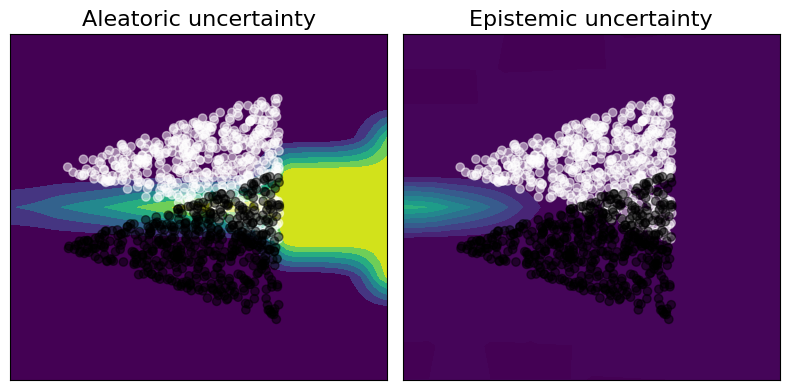

In [106]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.reset_orig()


cmap = pl.cm.binary
my_cmap = cmap(np.arange(cmap.N))
# my_cmap[:, 0] = 0.0
# my_cmap[:, -1] = 1.0
my_cmap = ListedColormap(my_cmap)


fig, axes =  plt.subplots(ncols=2, nrows=1, figsize=(8, 4), squeeze=False)    
ax_ale = axes[0][0]
ax_epi = axes[0][1]

cf_ale = ax_ale.contourf(xx, yy, it_aleatoric, antialiased=False, vmin=0.05, vmax=np.log(2.0))
ax_ale.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.5)
ax_ale.get_xaxis().set_ticks([])
ax_ale.get_yaxis().set_ticks([])
ax_ale.autoscale(False)

cf_epi = ax_epi.contourf(xx, yy, it_epistemic, antialiased=False, vmin=0.02, vmax=np.log(2.0))
ax_epi.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.5)
ax_epi.get_xaxis().set_ticks([])
ax_epi.get_yaxis().set_ticks([])
ax_epi.autoscale(False)

ax_ale.set_title("Aleatoric uncertainty", fontsize=16)
ax_epi.set_title("Epistemic uncertainty", fontsize=16)
# ax_ale.set_title("Information Theoretic MC-Dropout")


# ax_ale = axes[0][1]
# ax_epi = axes[1][1]

# cf_ale = ax_ale.contourf(xx, yy, gauss_logits_aleatoric, antialiased=True)
# ax_ale.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.05)
# ax_ale.get_xaxis().set_ticks([])
# ax_ale.get_yaxis().set_ticks([])
# ax_ale.autoscale(False)

# cf_epi = ax_epi.contourf(xx, yy, gauss_logits_epistemic, antialiased=True)
# ax_epi.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.05)
# ax_epi.get_xaxis().set_ticks([])
# ax_epi.get_yaxis().set_ticks([])
# ax_epi.autoscale(False)

# ax_ale.set_ylabel("Aleatoric")
# ax_epi.set_ylabel("Epistemic")
# ax_ale.set_title("Gaussian logits MC-Dropout")

fig.tight_layout()
plt.savefig('../figures/it_traingles.pdf')
plt.show()

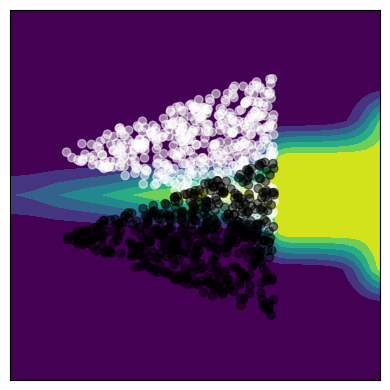

In [107]:
fig, axes =  plt.subplots(ncols=1, nrows=1, figsize=(4, 4), squeeze=False)    
ax_ale = axes[0][0]

cf_ale = ax_ale.contourf(xx, yy, it_aleatoric, antialiased=False, vmin=0.05, vmax=np.log(2.0))
ax_ale.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.5)
ax_ale.get_xaxis().set_ticks([])
ax_ale.get_yaxis().set_ticks([])
ax_ale.autoscale(False)

fig.tight_layout()
plt.savefig("../figures/it_triangles_ale.pdf",bbox_inches='tight')

plt.show()

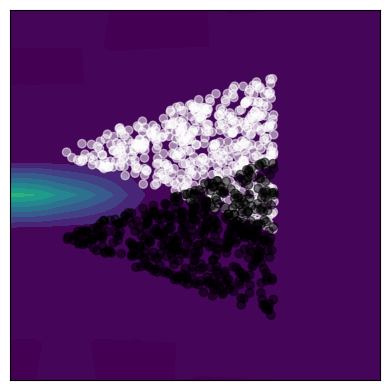

In [108]:
fig, axes =  plt.subplots(ncols=1, nrows=1, figsize=(4, 4), squeeze=False)    
ax_ale = axes[0][0]

cf_ale = ax_ale.contourf(xx, yy, it_epistemic, antialiased=False, vmin=0.02, vmax=np.log(2.0))
ax_ale.scatter(x[:, 0], x[:, 1], c=y, cmap=my_cmap, alpha=0.5)
ax_ale.get_xaxis().set_ticks([])
ax_ale.get_yaxis().set_ticks([])
ax_ale.autoscale(False)

fig.tight_layout()
plt.savefig("../figures/it_triangles_epi.pdf",bbox_inches='tight')

plt.show()